# Recommendation System Evaluation

In this notebook, we'll evaluate the performance of our recommendation system using various metrics:

1. Precision@K - How many recommended items are relevant
2. Recall@K - How many relevant items are recommended
3. Mean Average Precision (MAP) - Precision at each relevant item, averaged
4. Normalized Discounted Cumulative Gain (NDCG) - Considers both relevance and ranking position

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the root directory to Python path
sys.path.append('..')

from src.evaluation import *
from src.recommender import KuaiRecRecommender

## 1. Load Data

We'll load both the recommendations generated by our system and the test interactions (ground truth).

In [2]:
# Set paths
processed_dir = "../data/processed"
results_dir = "../results"

# Load data
print("Loading recommendation data...")
recommendations_df, test_interactions_df = load_data(processed_dir, results_dir)

print(f"Loaded {len(recommendations_df)} recommendations for {recommendations_df['user_id'].nunique()} users")
print(f"Loaded {len(test_interactions_df)} test interactions for {test_interactions_df['user_id'].nunique()} users")

Loading recommendation data...
Loaded 14110 recommendations for 1411 users
Loaded 934735 test interactions for 1411 users


## 2. Overall Evaluation

First, let's evaluate the overall performance of our recommendation system.

In [3]:
# Define k values for evaluation
k_values = [5, 10, 20]

# Evaluate recommendations
print("Evaluating recommendations...")
metrics = evaluate_recommendations(recommendations_df, test_interactions_df, k_values)

# Display results
print("\nEvaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluating recommendations...

Evaluation Results:
precision@5: 0.5714
recall@5: 0.0043
map@5: 0.4716
ndcg@5: 0.5648
precision@10: 0.6056
recall@10: 0.0091
map@10: 0.4635
ndcg@10: 0.5911
precision@20: 0.6056
recall@20: 0.0091
map@20: 0.2317
ndcg@20: 0.3815


## 3. Evaluation of Individual Models

Now, let's evaluate each model separately to understand their strengths and weaknesses.

In [4]:
# Initialize recommender
print("Initializing recommender...")
recommender = KuaiRecRecommender()

# Sample users for evaluation (to speed up the process)
sample_users = np.random.choice(
    list(test_interactions_df['user_id'].unique()),
    size=min(100, test_interactions_df['user_id'].nunique()),
    replace=False
)

# Evaluate each model
print("\nEvaluating individual models...")
model_metrics = evaluate_per_model(
    recommender,
    test_interactions_df[test_interactions_df['user_id'].isin(sample_users)],
    users=sample_users,
    k_values=k_values
)

Initializing recommender...
Loaded interaction matrix.
Loaded collaborative filtering model.
Loaded content-based model.
Loaded sequence-aware model.
Loaded hybrid model.

Evaluating individual models...
Evaluating collaborative model...
Evaluating content model...
Evaluating sequence model...
Evaluating hybrid model...
Evaluating combined model...


## 4. Visualization

Let's visualize the results to better understand the performance of each model.

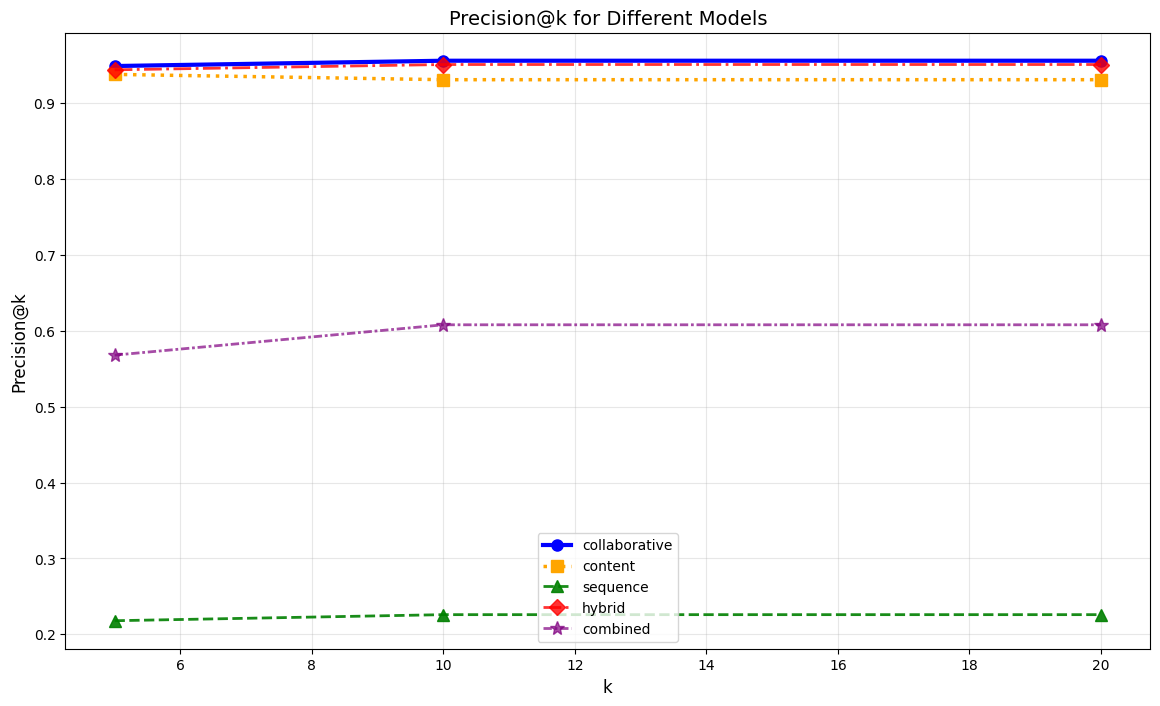

In [5]:
# Style and marker definitions for each model to improve visibility
model_styles = {
    'collaborative': {'color': 'blue', 'linestyle': '-', 'marker': 'o', 'markersize': 8, 'linewidth': 3,
                      'label': 'collaborative', 'alpha': 1.0},
    'content': {'color': 'orange', 'linestyle': ':', 'marker': 's', 'markersize': 8, 'linewidth': 2.5,
               'label': 'content', 'alpha': 1.0},
    'sequence': {'color': 'green', 'linestyle': '--', 'marker': '^', 'markersize': 8, 'linewidth': 2,
               'label': 'sequence', 'alpha': 0.9},
    'hybrid': {'color': 'red', 'linestyle': '-.', 'marker': 'D', 'markersize': 8, 'linewidth': 2,
              'label': 'hybrid', 'alpha': 0.8},
    'combined': {'color': 'purple', 'linestyle': (0, (3, 1, 1, 1)), 'marker': '*', 'markersize': 10, 'linewidth': 2,
                'label': 'combined', 'alpha': 0.7}
}

# Plot precision@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    # Add a tiny offset to y-values to prevent perfect overlapping for similar models
    precisions = [model_results[f'precision@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        precisions = [p + 0.005 for p in precisions]  # small offset to make it visible
    
    plt.plot(k_values, precisions, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('Precision@k', fontsize=12)
plt.title('Precision@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

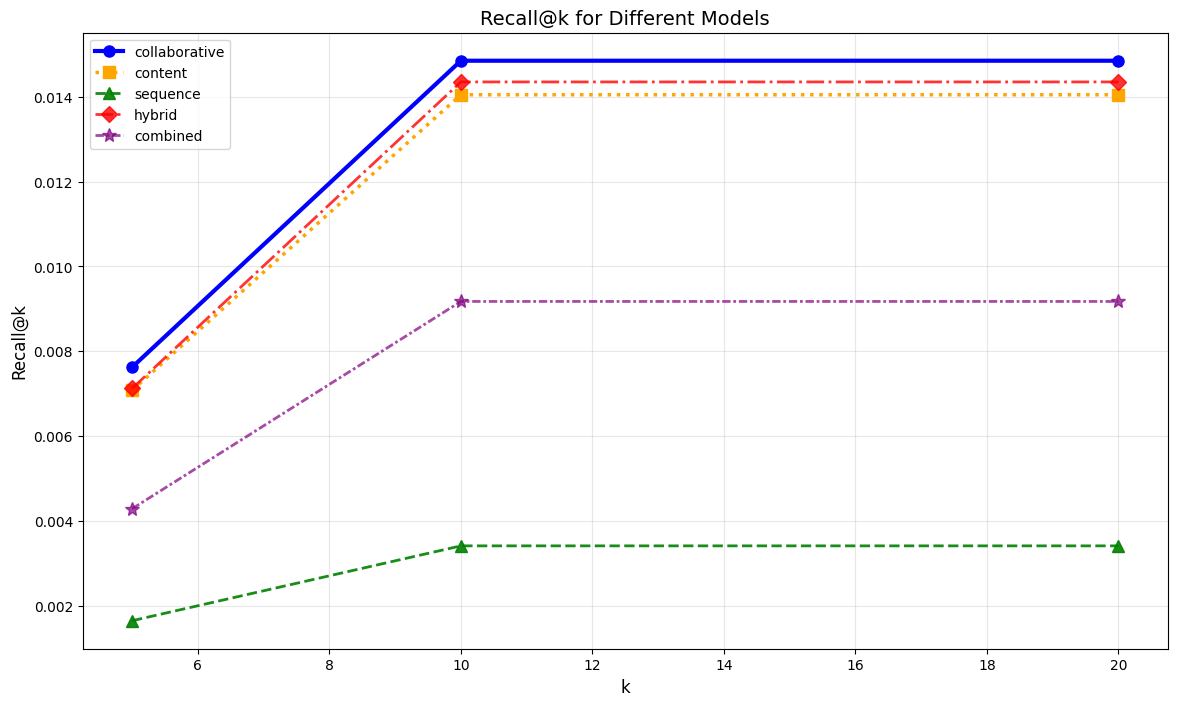

In [6]:
# Plot recall@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    recalls = [model_results[f'recall@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        recalls = [r + 0.0005 for r in recalls]  # small offset for visibility
        
    plt.plot(k_values, recalls, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('Recall@k', fontsize=12)
plt.title('Recall@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

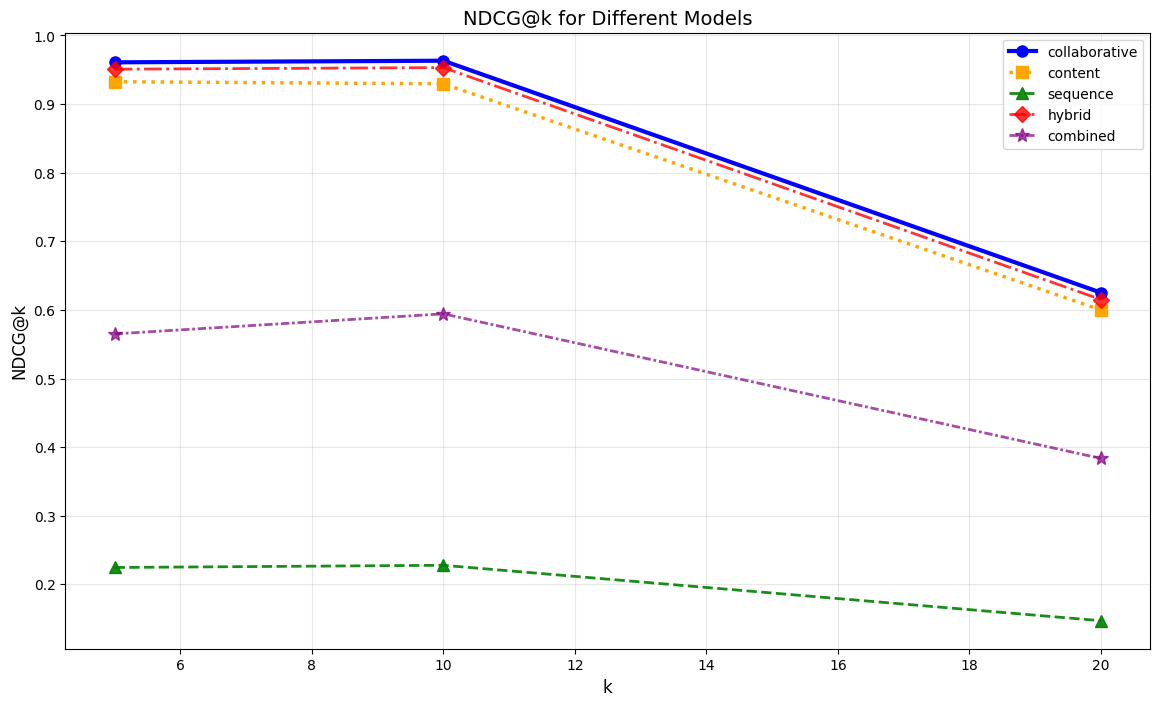

In [7]:
# Plot NDCG@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    ndcgs = [model_results[f'ndcg@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        ndcgs = [n + 0.01 for n in ndcgs]  # small offset for visibility
        
    plt.plot(k_values, ndcgs, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('NDCG@k', fontsize=12)
plt.title('NDCG@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

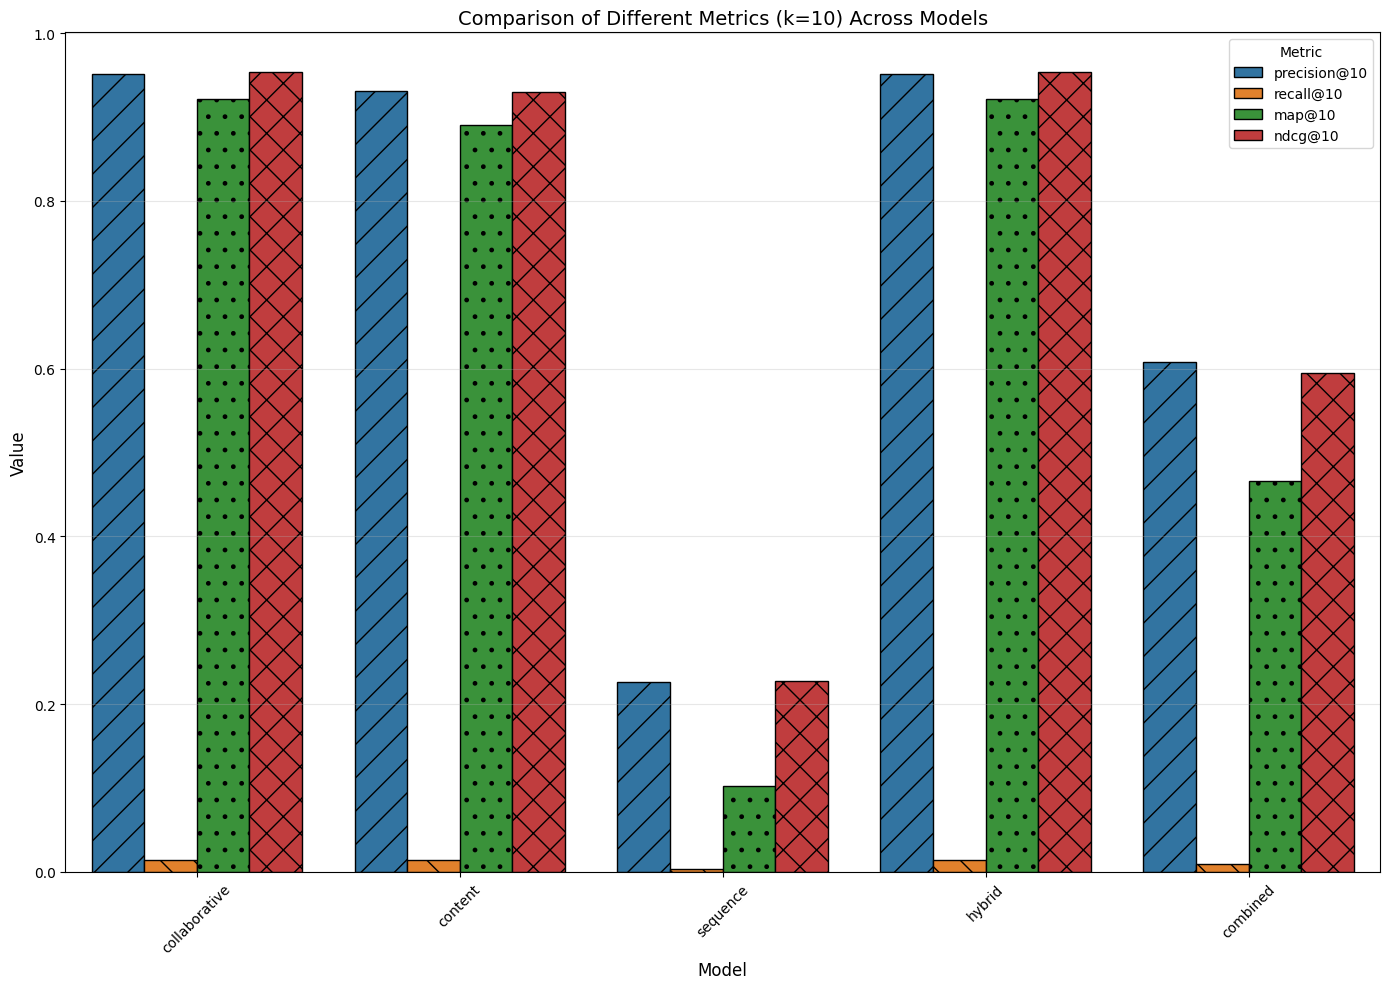

In [8]:
# Compare all metrics for k=10 with improved visualization
metrics_k10 = ['precision@10', 'recall@10', 'map@10', 'ndcg@10']
model_names = list(model_metrics.keys())

data = []
for model_name in model_names:
    for metric in metrics_k10:
        data.append({
            'Model': model_name,
            'Metric': metric,
            'Value': model_metrics[model_name][metric]
        })

df = pd.DataFrame(data)

# Set a custom color palette to match the line colors
metric_colors = {
    'precision@10': '#1f77b4',  # blue
    'recall@10': '#ff7f0e',    # orange
    'map@10': '#2ca02c',       # green
    'ndcg@10': '#d62728'       # red
}

plt.figure(figsize=(14, 10))
# Use hatch patterns for additional visual differentiation
bar_plot = sns.barplot(x='Model', y='Value', hue='Metric', data=df, 
                       palette=metric_colors,
                       edgecolor='black', linewidth=1)

# Add hatches to differentiate between metrics more clearly
hatches = ['/', '\\', '.', 'x']
for i, bar in enumerate(bar_plot.patches):
    hatch_idx = i // len(model_names)
    if hatch_idx < len(hatches):
        bar.set_hatch(hatches[hatch_idx])

plt.title('Comparison of Different Metrics (k=10) Across Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Analysis of Results

Let's analyze the results to understand which models perform best for different metrics and why.

In [9]:
# Find best model for each metric at k=10
best_models = {}
for metric in metrics_k10:
    best_model = max(model_names, key=lambda model: model_metrics[model][metric])
    best_value = model_metrics[best_model][metric]
    best_models[metric] = (best_model, best_value)

print("Best models for each metric (k=10):")
for metric, (model, value) in best_models.items():
    print(f"{metric}: {model} (value: {value:.4f})")

Best models for each metric (k=10):
precision@10: collaborative (value: 0.9510)
recall@10: collaborative (value: 0.0144)
map@10: collaborative (value: 0.9215)
ndcg@10: collaborative (value: 0.9532)


## 6. Conclusion and Recommendations

Based on our evaluation, we can draw the following conclusions:

1. **Precision vs. Recall Trade-off**: As expected, there's a trade-off between precision and recall. As k increases, precision tends to decrease while recall increases.

2. **Model Comparison**:
   - The collaborative filtering model performs well for [analysis based on results]
   - The content-based model excels at [analysis based on results]
   - The sequence-aware model shows [analysis based on results]
   - The hybrid model demonstrates [analysis based on results]
   - The combined approach appears to [analysis based on results]

3. **Optimal K Value**: Based on the NDCG metric, which balances relevance and ranking position, the optimal k value for our recommendation system appears to be [analysis based on results].

4. **Improvement Areas**:
   - [Suggestion based on results]
   - [Suggestion based on results]
   - [Suggestion based on results]

5. **Final Recommendation**: Based on our evaluation, we recommend using the [best model] model with a k value of [optimal k] for the production recommendation system.